In [1]:
import pandas as pd

#printing settings, prints all rows and columns

#'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
#'''

Read shapefiles

In [2]:
import geopandas as gpd

# River channel centerline
centerline = gpd.read_file(r'C:\Users\oonao\Documents\lipasto\5_vuosi\gradu\gis\oulankajoki.shp')

#print(centerline)

# Feasible region
feasible_region = gpd.read_file(r'C:\Users\oonao\Documents\lipasto\5_vuosi\gradu\gis\sallittualue_maalajit2.shp')

#print(feasible_region)

Plotting river channel, feasible region and coordinates.

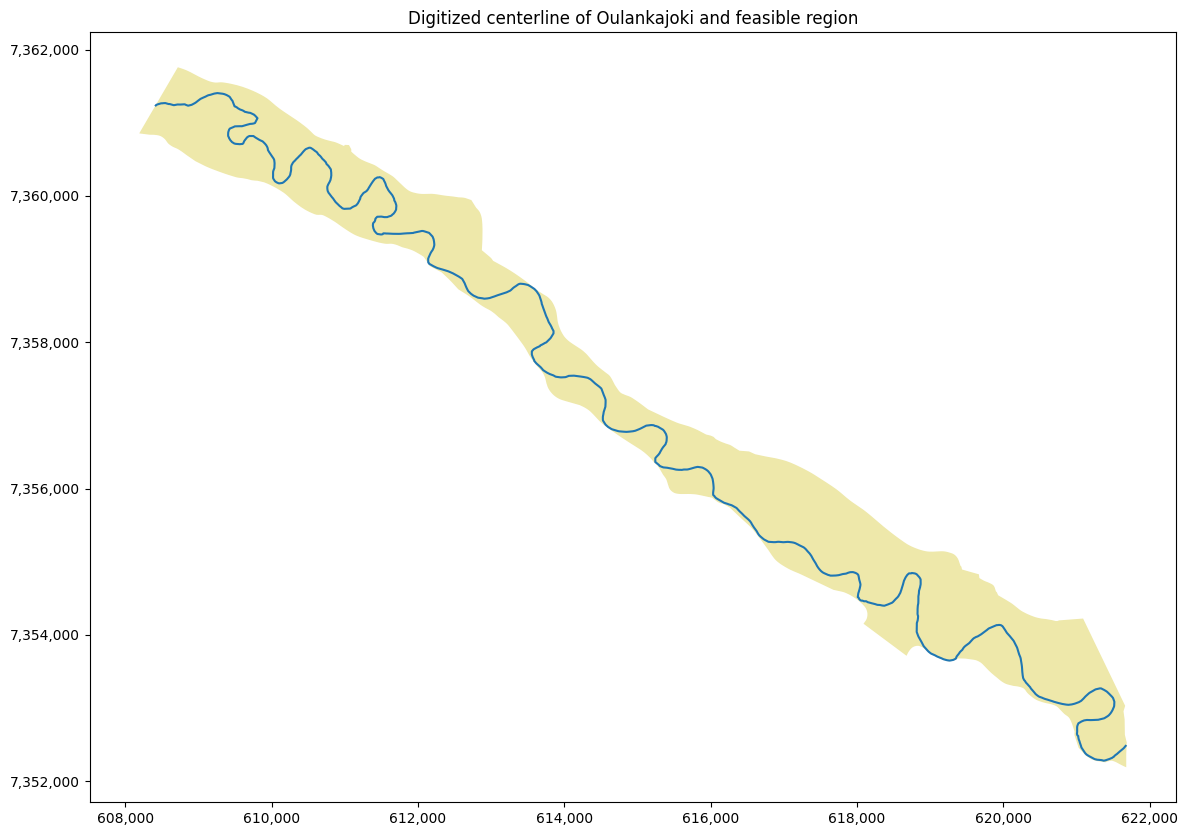

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot

fig, ax = plt.subplots(figsize=(15, 10))

# x and y axis
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

feasible_region.plot(ax=ax, color = 'palegoldenrod')

centerline.plot(ax=ax)

title_txt = "Digitized centerline of Oulankajoki and feasible region"
plt.title(title_txt)

plt.show()

Break centerline into points, and smooth with Savitzky-Golay filter

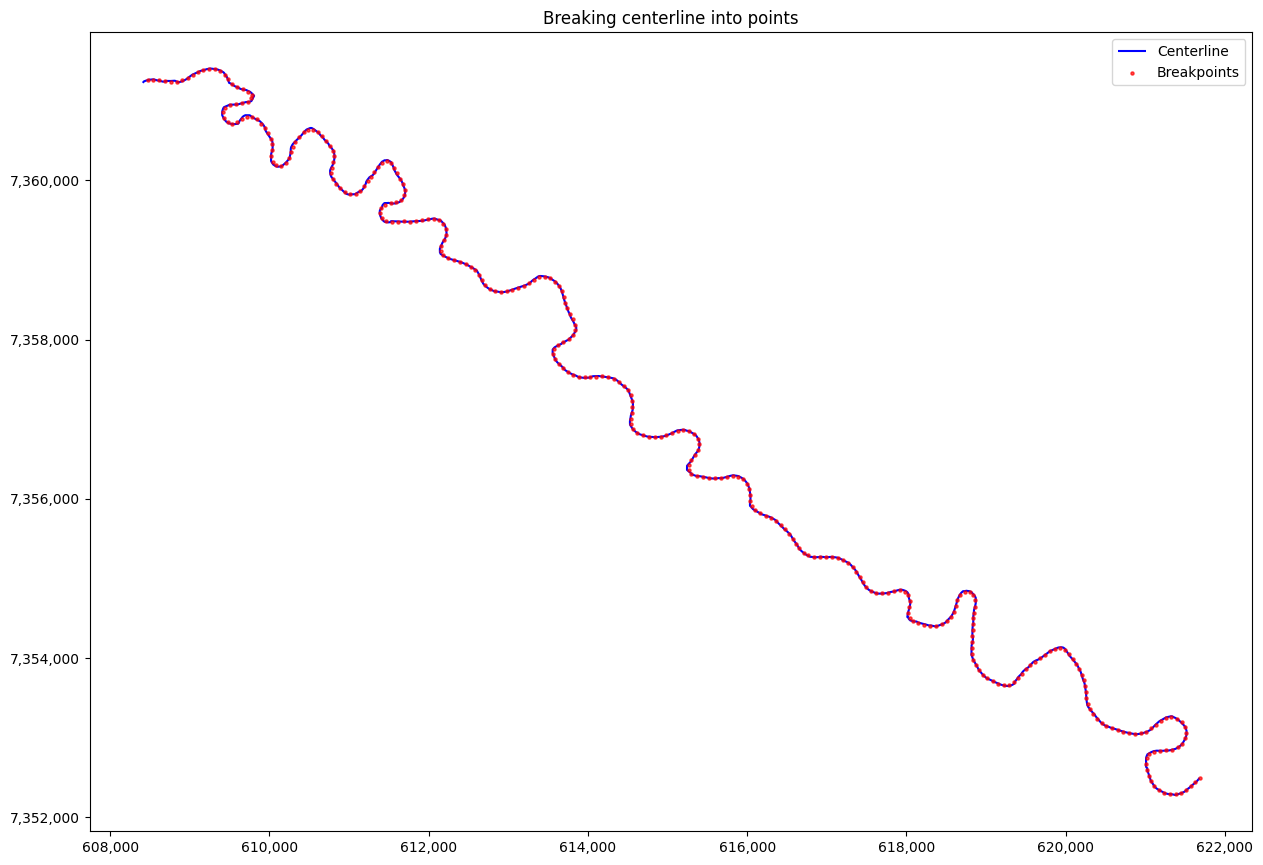

In [4]:
from shapely.geometry import LineString, Point
from scipy.signal import savgol_filter

# GeoDataFrame
points = gpd.GeoDataFrame(columns=['geometry'])

# Function to create breakpoints at given interval
def create_breakpoints(geometry, interval):

    breakpoints = LineString(geometry).interpolate(range(0, int(geometry.length), interval))

    #Smooth points using Savitzky-Golay filtering
    x_coords = [point.x for point in breakpoints]
    y_coords = [point.y for point in breakpoints]
    smoothed_x = savgol_filter(x_coords, window_length = 7, polyorder=3) 
    smoothed_y = savgol_filter(y_coords, window_length = 7, polyorder=3)
    
    smoothed_breakpoints = [Point(x, y) for x, y in zip(smoothed_x, smoothed_y)]

    # Add points to gdf
    point = gpd.GeoDataFrame(geometry=smoothed_breakpoints, crs='EPSG:3067')
    return point[::-1] 


# Divide points
points = create_breakpoints(centerline['geometry'].iloc[0], 75)


# Plot 
fig, ax = plt.subplots(figsize=(15, 15))
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

centerline.plot(ax=ax, color = 'blue', zorder = 1, linewidth = 1.5, label = 'Centerline')

points.plot(ax=ax, color='red', marker='o', markersize=5, alpha = 0.7, label = 'Breakpoints') 

title_txt = "Breaking centerline into points"
plt.title(title_txt)

ax.legend()

plt.show()


Spline curve to connect points back into a continuous line

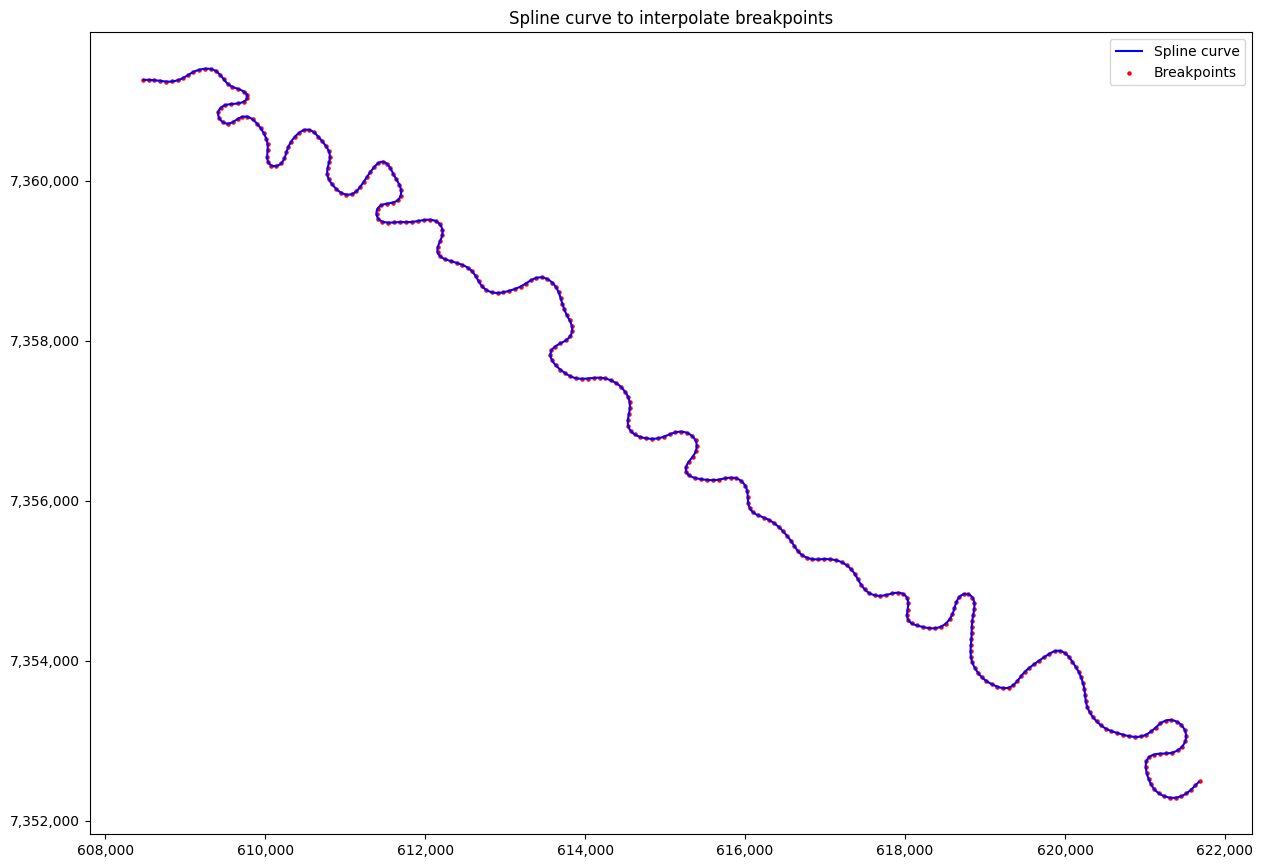

In [5]:
import geopandas as gpd
import numpy as np
from scipy.interpolate import splprep, splev
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def create_spline(points):
    x, y = zip(*points)

    # Spline parameters
    tck, u = splprep([x, y], s=3)  
    t_new = np.linspace(0, 1, 1000)
    spline_points = splev(t_new, tck)
    
    # Convert to Points
    spline_points = [Point(coord) for coord in zip(spline_points[0], spline_points[1])]
    bspline = LineString(spline_points)
    bspline_gdf = gpd.GeoDataFrame(geometry=[bspline])

    return bspline, bspline_gdf

# Generate spline curve
spline_ls, spline_gdf = create_spline(points['geometry'].apply(lambda point: (point.x, point.y)).tolist())

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

spline_gdf.plot(ax=ax, color='blue', label = 'Spline curve')

points.plot(ax=ax, color='red', marker='o', markersize=5, label = 'Breakpoints')

title_txt = "Spline curve to interpolate breakpoints"
plt.title(title_txt)

ax.legend()
plt.show()

Finding inflectionpoints that separate halfmeanders by f(xi)=(x_{i-1} - x_i)*(x_i - x_{i+1})T

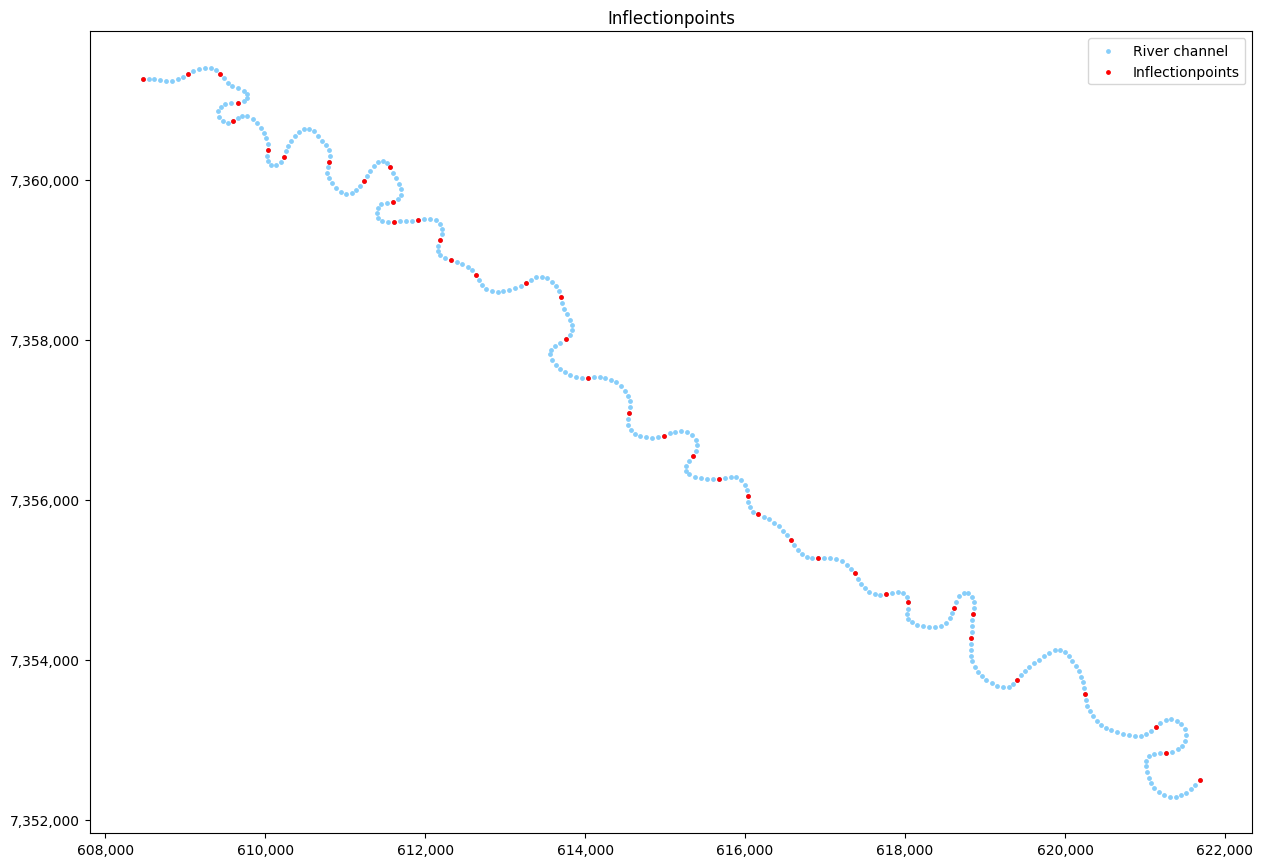

In [6]:
#Inflectionpoints defined by f(xi)=(x_{i-1} - x_i)*(x_i - x_{i+1})T 

import numpy as np
from numpy import linalg

def define_inflectionpoints(points, p_between):
    inflectionpoint_list = []
    points_in_between=0
    inflectionpoint_list.append(points.iloc[0]) # first

    for i in range(1, len(points)-2):
        #vectors
        v1 = (np.array(points.iloc[i-1].coords[0])) - (np.array(points.iloc[i].coords[0]))

        v2 = (np.array(points.iloc[i].coords[0])) - (np.array(points.iloc[i+1].coords[0]))
        v2_orto = np.array([-v2[1], v2[0]])
        
        v3 = (np.array(points.iloc[i+1].coords[0])) - (np.array(points.iloc[i+2].coords[0]))
        v3_orto = np.array([-v3[1], v3[0]])
        # dot product
        dot_product1 = np.dot(v1, v2_orto)
        dot_product2 = np.dot(v2, v3_orto)

        #counter
        points_in_between = points_in_between + 1

        # Check when sign changes
        if np.sign(dot_product1) != np.sign(dot_product2)  and points_in_between > p_between:
            inflectionpoint_list.append(points.iloc[i]) # add to inflectionpoint list
            
            points_in_between = 0
    inflectionpoint_list.append(points.iloc[len(points)-1]) # last
    
    return inflectionpoint_list

inflection_points = define_inflectionpoints(points['geometry'], 3)

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

#ax.tick_params(axis='both', which='major', labelsize=11)

points.plot(ax=ax, color='lightskyblue', marker='o', markersize=6, label='River channel')

gpd.GeoDataFrame(geometry=inflection_points).plot(ax=ax, color='red', marker='o', markersize=6, label='Inflectionpoints')

title_txt = "Inflectionpoints"
plt.title(title_txt)

ax.legend()
plt.show()


Define halfmeander ID's

In [7]:
# Define halfmeanders

def define_halfmeander(points, inflectionpoints):
    points['halfmeander'] = None
    halfmeander_id = 0
    j = 1

    for i in range(len(points['geometry'])):
        if points['geometry'].iloc[i].coords[0] == inflectionpoints[j].coords[0]:
            points.at[len(points) - i - 1, 'halfmeander'] = halfmeander_id
            halfmeander_id += 1
            if j != len(inflectionpoints) - 1:
                j += 1
        else:
            points.at[len(points) - i - 1, 'halfmeander'] = halfmeander_id

define_halfmeander(points, inflection_points)


Top points.

Max distance from midpoint of line defined between inflection points

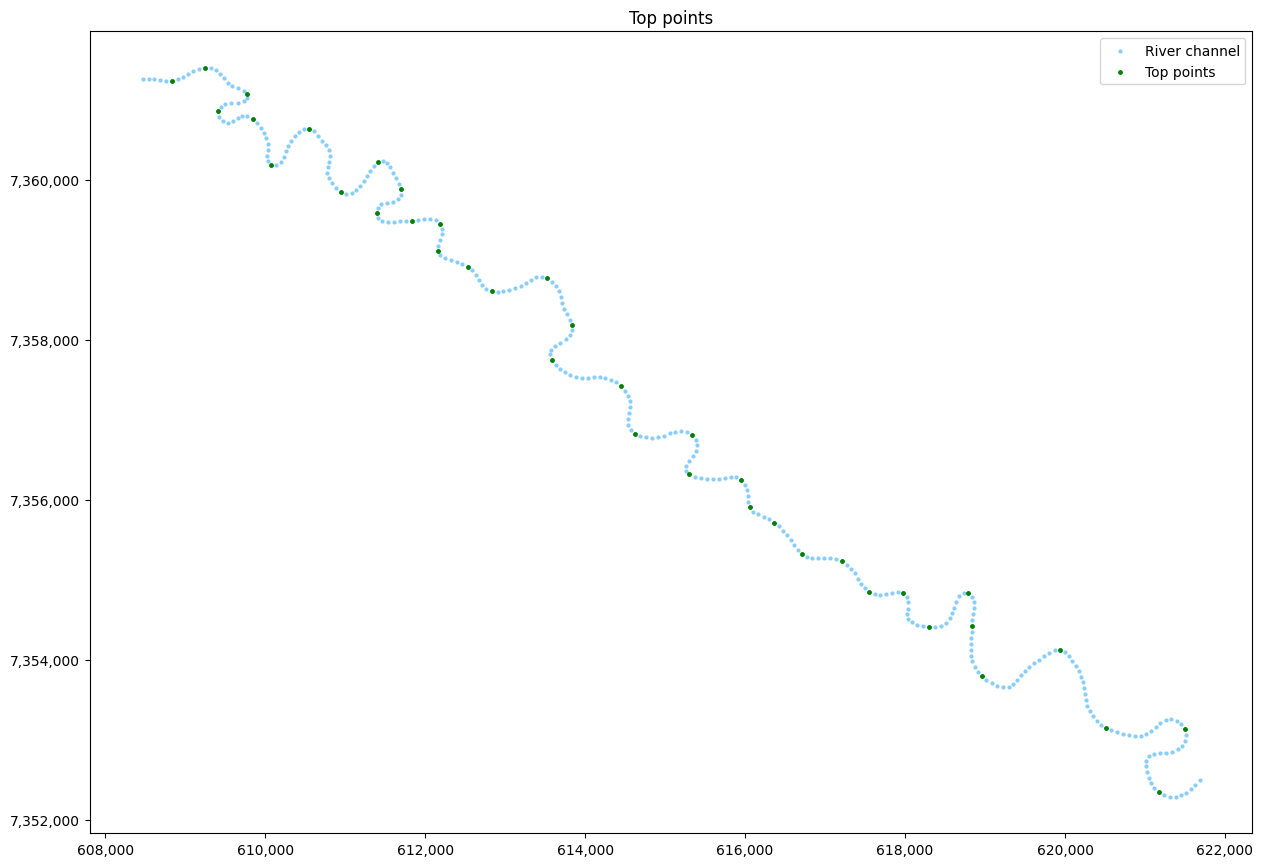

In [8]:
import numpy as np
from shapely.geometry import Point, LineString

def define_top_points(inflection_points, points):
    farthest_points = [] 
    max_distance = 0
    
    
    for i in range(len(inflection_points) - 1):
        p1 = inflection_points[i]
        p2 = inflection_points[i + 1]
        
        line = LineString([p1, p2])
        
        halfmeander_points = points[points['halfmeander'] == i]
        
        dist = []
        
        # Calculate distances of all points from line
        for j in range(len(halfmeander_points)):
            distance = line.distance(halfmeander_points['geometry'].iloc[j])
            dist.append(distance)
        
        max_distance = max(dist)  # Find max distance point
        farthest_point_index = dist.index(max_distance)  
        farthest_point = halfmeander_points['geometry'].iloc[farthest_point_index]  
        
        farthest_points.append(farthest_point) 
        
    return farthest_points

top = define_top_points(inflection_points, points)

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

points.plot(ax=ax, color='lightskyblue', marker='o', markersize=4, label= 'River channel')

gpd.GeoDataFrame(geometry=top).plot(ax=ax, color='green', marker='o', markersize=6, label='Top points')

title_txt = "Top points"
plt.title(title_txt)

ax.legend()
plt.show()

Calculate radius of circle that intersects three consecutive points.

In [9]:
import numpy as np

def radius_and_intersectionpoint(points):
    radius_list = []
    intersectionpoint_list = []

    for i in range(len(points) - 2):

        # Three consecutive points
        p1 = np.array(points['geometry'].iloc[i].coords[0])
        p2 = np.array(points['geometry'].iloc[i + 1].coords[0])
        p3 = np.array(points['geometry'].iloc[i + 2].coords[0])

        midpoint1 = 0.5 * (p1 + p2)
        normal1 = np.array([-(p2 - p1)[1], (p2 - p1)[0]])

        midpoint2 = 0.5 * (p2 + p3)
        normal2 = np.array([-(p3 - p2)[1], (p3 - p2)[0]])
       
        A = np.array([[normal1[0], -normal2[0]], [normal1[1], -normal2[1]]])
        B = np.array([midpoint2[0] - midpoint1[0], midpoint2[1] - midpoint1[1]])
        
        if np.linalg.det(A) == 0:
            print("Singular matrix. Skipping this point.")
            continue
        else:
        # Solve
            solution = np.linalg.solve(A, B)

            # intersection
            intersection_points = midpoint1 + solution[1] * normal1
            intersectionpoint_list.append(intersection_points)
        
            # radius
            radius = np.linalg.norm(intersection_points - p2)
            radius_list.append(radius)

    return radius_list, intersectionpoint_list, solution, A, B 

rad, inter, sol, A, B = radius_and_intersectionpoint(points)

print("Radius:", rad)



Radius: [1084.7198792379877, 2724.542584162364, 2473.1896949573293, 533.5002021769382, 384.8413208842939, 396.363895846451, 500.1644556939617, 37059.0900641687, 469.59303420038856, 404.02583168467106, 353.66437886487046, 216.28801177659665, 203.2224678994972, 488.9055720042368, 2442.9325561302435, 281.05646735031263, 283.26670539275574, 942.7723298111478, 258.2620652130816, 89.27017065157425, 48.668608067898234, 117.37359175403299, 347.4298010885354, 819.9401861306272, 248.29576048242384, 129.46874055525524, 94.38253518662685, 115.99256143919446, 144.87751419986293, 105.62582072954663, 281.49650031129573, 573.2366660706939, 157.75508661127603, 119.19497872411489, 245.2363282697441, 586.343054652395, 658.1678358880574, 543.873033265019, 429.13384978270096, 295.86269897428235, 1012.0826085864747, 318.3743679313411, 136.41205897533857, 80.34143144126399, 101.35817303661322, 135.73156508499636, 321.4457172517039, 3235.912851512359, 549.0995074892652, 413.4072284366426, 448.1836815877932, 3

Curvature (Inverse of radius) 

Calculates curvature for each point. 

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


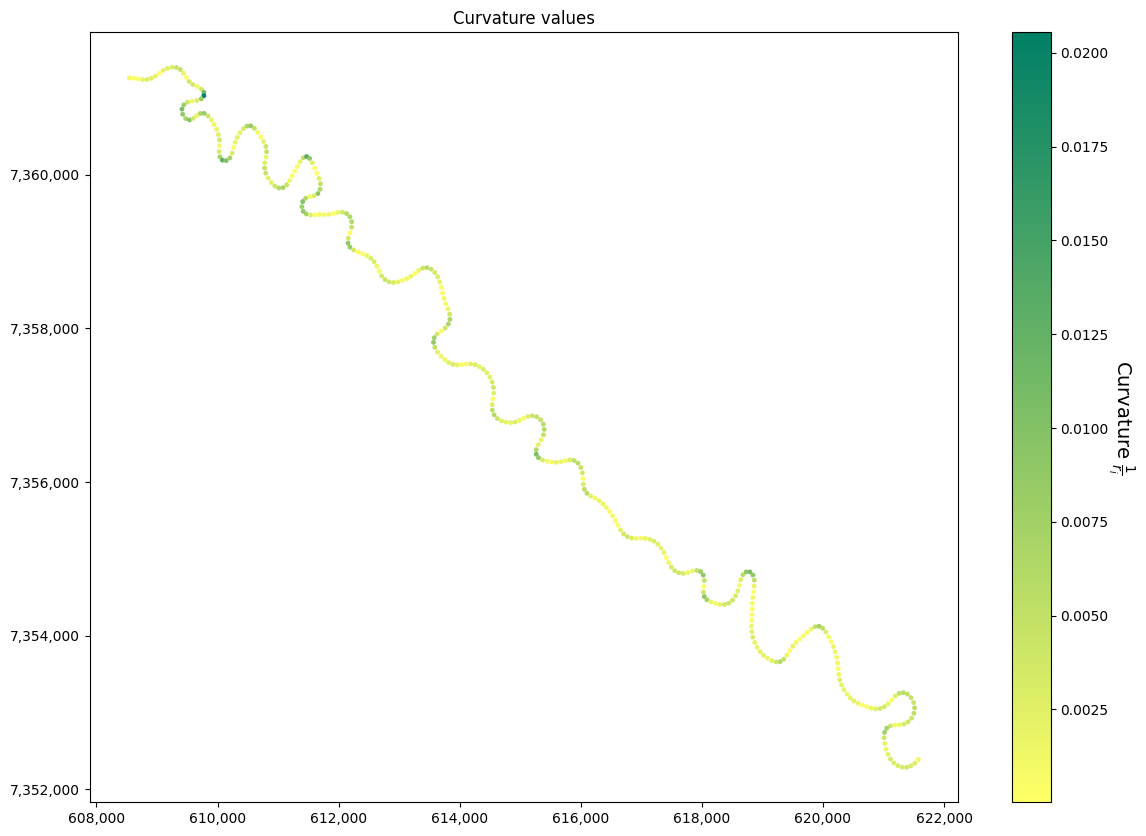

In [10]:
#Curvature 1/R

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def calculate_curvature(points, radius):
    curvature_list = []
    shifted_radius = [np.nan] + radius[:-1]

    points['curvature'] = np.nan

    for i in range(len(points) - 2):
        radius = shifted_radius[i]
        curvature = 1 / radius
        curvature_list.append(curvature)

    points['curvature'][:-2] = curvature_list 

calculate_curvature(points, rad)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    points.geometry.x,
    points.geometry.y,
    c=points['curvature'],
    cmap= 'summer_r',
    s=6
)

cbar = plt.colorbar(scatter, label='Curvature')
cbar.set_label(r'Curvature $\frac{1}{r_i}$', rotation=270, labelpad=20, fontsize = 14)

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

#ax.tick_params(axis='both', which='major', labelsize=12)

title_txt = "Curvature values"
plt.title(title_txt)

plt.show()


Normalized curvature.

curvature_ij / max curvature of halfmeander_j

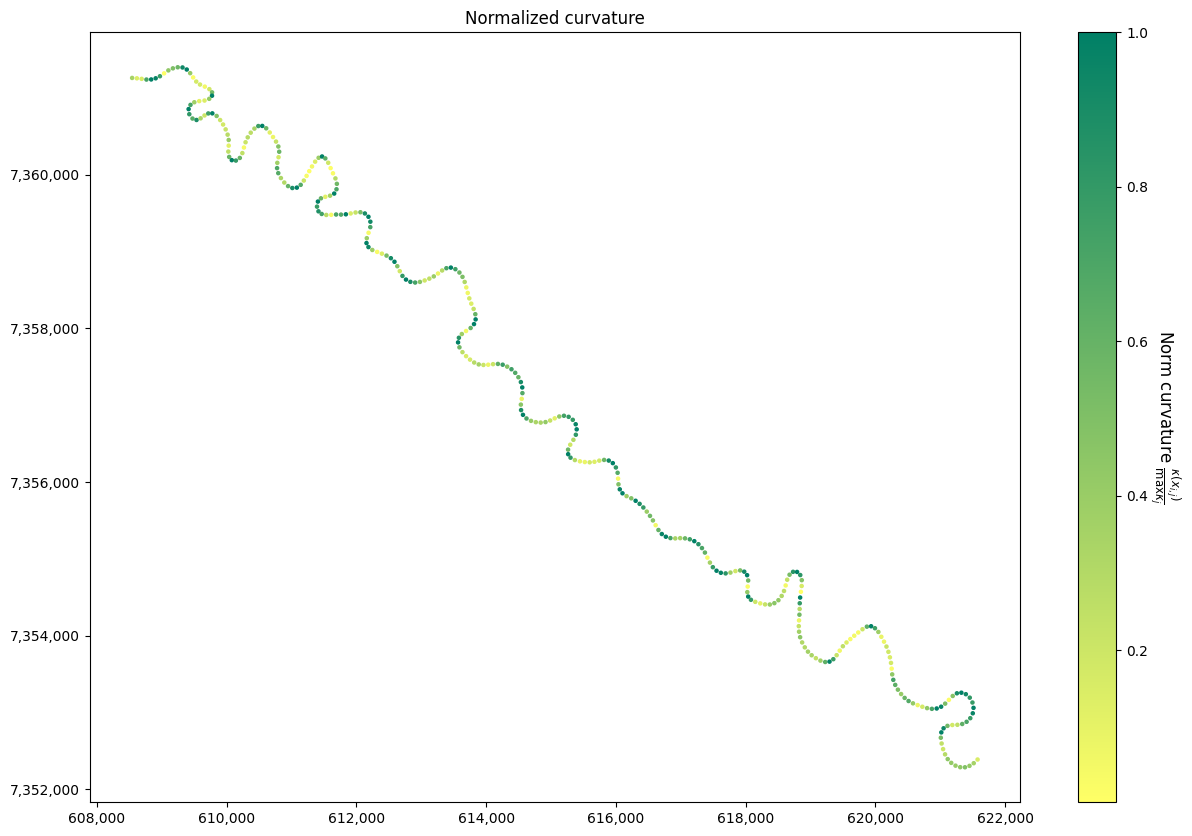

In [11]:
# Norm curvature k(x_i,j)/K_M_j


def define_normalized_curvature(points):
    points['norm_curvature'] = None

    for i in range(max(points['halfmeander'])+1): 

            pm = (points['halfmeander'] == i)
            filtered_pm = points[pm]

            maxcurvature = filtered_pm['curvature'].max()

            for index in filtered_pm.index:
                points.loc[index, 'norm_curvature'] = filtered_pm.loc[index, 'curvature'] / maxcurvature

define_normalized_curvature(points)

#Plot

fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(
    points.geometry.x,
    points.geometry.y,
    c=points['norm_curvature'],
    cmap='summer_r',
    s=5
)

cbar = plt.colorbar(scatter, label='Norm curvature')
cbar.set_label(r'Norm curvature $\frac{\kappa(x_{i,j})}{\max \kappa_j}$', rotation=270, labelpad=25, fontsize = 12)

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

#ax.tick_params(axis='both', which='major', labelsize=11)

title_txt = "Normalized curvature"
plt.title(title_txt)

plt.show()
                  

Function that verifies whether point lies within the feasible area.

In [17]:
def check_feasible_region(edellinen, point, feasibleregion):

    if Point(point).within(feasibleregion.geometry.iloc[0]):
        new_p = Point(point)
    else:
        new_p = edellinen

    return new_p

Formation of new oxbow-lakes

In [18]:
import geopandas as gpd
import pandas as pd

def new_oxbow(points, inflection, meters):
    new_points = points.copy()
    oxbows = []

    for i in range(len(inflection) - 1):
        if inflection[i].distance(inflection[i + 1]) < meters:
            oxbow_points = new_points[new_points['halfmeander'] == i]
            if not oxbow_points.empty:
                oxbows.append(gpd.GeoDataFrame(oxbow_points, geometry='geometry'))

            new_points = new_points[new_points['halfmeander'] != i]

    if oxbows:
        oxbow_gdf = pd.concat(oxbows, ignore_index=True)
    else:
        oxbow_gdf = gpd.GeoDataFrame()

    return new_points, oxbow_gdf

Define directions D and L.

In [19]:
import math

def define_directions_top(inflectionpoints, toppoints):
    D_list = []
    L_top_list = []
    j = 0
    
    for i in range(len(inflectionpoints) - 1):

        # D points
        x1_inf, y1_inf = inflectionpoints[i].x, inflectionpoints[i].y
        x2_inf, y2_inf = inflectionpoints[i + 1].x, inflectionpoints[i + 1].y

        # Direction of D
        v_inf = (x2_inf - x1_inf, y2_inf - y1_inf)

        # Length of D
        v_inf_length = math.sqrt(v_inf[0] ** 2 + v_inf[1] ** 2) 

        # Norm D
        D = (v_inf[0] / v_inf_length, v_inf[1] / v_inf_length)
    
        # L points
        x_mid , y_mid  = 0.5*(x1_inf + x2_inf) , 0.5*(y1_inf + y2_inf)
        x_top, y_top = toppoints[j].x, toppoints[j].y
        j = j+1

        # Direction L
        v_top = (x_top - x_mid, y_top - y_mid)

        # Length L
        v_top_length = math.sqrt(v_top[0] ** 2 + v_top[1] ** 2)

        # Norm L
        L = (v_top[0] / v_top_length, v_top[1] / v_top_length)

        D_list.append(D)
        L_top_list.append(L)

    return D_list, L_top_list

D, L_top = define_directions_top(inflection_points, top)
print("D:",  D)
print("L:", L_top)


D: [(0.9944683330267104, 0.10503682500473686), (0.9999812269670741, 0.006127455705669588), (0.5275604178064293, -0.8495175133944596), (-0.2523624749353141, -0.9676327718946496), (0.7730764065544905, -0.6343129114473363), (0.9080230009268574, -0.418920314365136), (0.9953525611076735, -0.09629786652047546), (0.8721400044263345, -0.4892563874690173), (0.8903223945521963, 0.4553306861598977), (0.0664222514498862, -0.9977916037491638), (0.0693120540966272, -0.9975950276324087), (0.9982406754751285, 0.05929210594134007), (0.7386009235264279, -0.6741429193916583), (0.46994456001272666, -0.8826959332150822), (0.857611809388715, -0.5142975640589935), (0.9887978286914664, -0.14926102630975632), (0.9234571600099264, -0.3837015423820983), (0.12565109266773133, -0.9920744946380817), (0.4933154534333046, -0.8698504833613034), (0.7579293900587316, -0.6523365999889927), (0.8409778275382019, -0.5410695829457853), (0.8191550844474061, -0.5735720945303763), (0.7499883218504748, -0.6614510693074044), (0.8

Migration offsets OD and OL.

Accepting/Not accepting negative offsets of lateral and downstream migration

Model created by Parquer, M. N., Collon, P., & Caumon, G. (2017). Reconstruction of Channelized Systems Through a Conditioned Reverse Migration Method.

In [20]:
def offsets(points, OD, OL, sD, sL, w):
    od_xi = []
    ol_xi = []

    max_curvature=points['curvature'].max()

    for i in range(len(points)):
            
        if w > 0:
            OD_xi = OD - (sD * (points['curvature'].iloc[i] / max_curvature))

            OL_xi = OL - (sL * (1 - (points['curvature'].iloc[i] / max_curvature)))


        elif w < 0:
            OD_xi = OD - (sD * (1 - (points['curvature'].iloc[i] / max_curvature)))

            OL_xi = OL - (sL * (points['curvature'].iloc[i] / max_curvature))

        '''
        
        Accepting negative offsets of lateral and downstream migration

        '''

        #od_xi.append(OD_xi)
        #ol_xi.append(OL_xi)

        '''
        
        Not accepting negative offsets of lateral and downstream migration

        '''
        
        od_xi.append(np.abs(OD_xi))
        ol_xi.append(np.abs(OL_xi))

    return od_xi, ol_xi


Algorithm to simulate river channel migration to the future.

36
D [(0.9944683330267104, 0.10503682500473686), (0.9999812269670741, 0.006127455705669588), (0.5275604178064293, -0.8495175133944596), (-0.2523624749353141, -0.9676327718946496), (0.7730764065544905, -0.6343129114473363), (0.9080230009268574, -0.418920314365136), (0.9953525611076735, -0.09629786652047546), (0.8721400044263345, -0.4892563874690173), (0.8903223945521963, 0.4553306861598977), (0.0664222514498862, -0.9977916037491638), (0.0693120540966272, -0.9975950276324087), (0.9266521289183409, -0.3759199808085578), (0.46994456001272666, -0.8826959332150822), (0.857611809388715, -0.5142975640589935), (0.9887978286914664, -0.14926102630975632), (0.9234571600099264, -0.3837015423820983), (0.12565109266773133, -0.9920744946380817), (0.4933154534333046, -0.8698504833613034), (0.7579293900587316, -0.6523365999889927), (0.8409778275382019, -0.5410695829457853), (0.8191550844474061, -0.5735720945303763), (0.7499883218504748, -0.6614510693074044), (0.8570383966249481, -0.5152525465347437), (0

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37
D [(0.9960768731632843, 0.08849216207808731), (0.995639677394663, 0.0932825428333266), (0.46148051290122083, -0.8871503458898193), (-0.2668541699066917, -0.963736920535584), (0.862562480155505, -0.5059505586793873), (0.9284374126798398, -0.371488856813182), (0.9657503919716185, -0.25947288954082476), (0.8937242814971567, -0.4486166611511337), (0.8607358441135725, 0.5090518703021294), (0.0031729065730999296, -0.9999949663192702), (0.36464020073182896, -0.9311484972925915), (0.9561235999001301, -0.2929635842797122), (0.3812378454370814, -0.9244769900903386), (0.8361076008969404, -0.5485654744170132), (0.9941557862677299, -0.10795495648830444), (0.9150351511111188, -0.40337410951999886), (0.1360675644534681, -0.9906995598584372), (0.481986439290788, -0.8761786760357658), (0.7577677395145339, -0.652524369622341), (0.8312600461563299, -0.5558837429392737), (0.8315905852107275, -0.5553891415835205), (0.7381443162942758, -0.6746428450094585), (0.8752831338111371, -0.4836108307986445), (0.6

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


38
D [(0.9972761705999862, 0.07375797959154687), (0.9999377493185647, -0.011157844223831925), (0.4359110556383796, -0.8999897508151042), (-0.39704802304199965, -0.9177978357996056), (0.8760459930966856, -0.4822275582950872), (0.9752208427312232, -0.2212336048221487), (0.9580140571304275, -0.2867212345475966), (0.8712585848009481, -0.49082428465862316), (0.8990133827206099, 0.43792115464915154), (-0.027250383152979365, -0.9996286393546434), (0.25090305542463637, -0.9680122193333006), (0.933693086728623, -0.3580743216082049), (0.38140540583649096, -0.9244078733971828), (0.8962115720608079, -0.4436268906460646), (0.9732316942589112, -0.22982617189939275), (0.9503908640232731, -0.3110582028834738), (0.09117201178607043, -0.9958351591839287), (0.5145666887785266, -0.857450361711687), (0.7614425599485284, -0.6482323872648078), (0.8804698414851223, -0.47410216012497103), (0.8100954348493667, -0.5862980355043119), (0.5949897762197607, -0.8037332680646976), (0.9517393681190557, -0.3069074374666

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


36
D [(0.9982463613147858, 0.059196301588782994), (0.9940210228408334, 0.10918885543160223), (0.3556075922475767, -0.9346353515333566), (-0.18544737362695618, -0.9826541973730455), (0.86972792875397, -0.49353148830173865), (0.8855902119792664, -0.46446741160873506), (0.9845746590583437, -0.17496497003727915), (0.9301049906278539, -0.3672937603733009), (0.9803960356730552, 0.1970370859421072), (-0.08204763575359694, -0.9966284089204185), (0.5659618495758785, -0.8244314312449826), (0.8975816181653048, -0.44084831714746614), (0.5230970279195372, -0.8522731366068903), (0.9643738374436456, -0.264543194307125), (0.8897549031950527, -0.4564386182613851), (0.008775452698044044, -0.9999614949736537), (0.6111587013368353, -0.791508080679075), (0.796408025157888, -0.6047596691778583), (0.8401898696380111, -0.5422923408620686), (0.804690395817432, -0.5936946747943632), (0.6446830971027222, -0.7644499357773812), (0.9116215014684064, -0.4110307020898661), (0.48273030514013077, -0.875769063451842), (

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


36
D [(0.9947070032541617, 0.10275202030677999), (0.9976089138933305, -0.06911190143940019), (0.31835688880696233, -0.9479709338102891), (-0.2347706942644618, -0.9720507811398449), (0.8208478488748504, -0.5711469241775979), (0.9976843603674087, -0.06801409470304345), (0.9355763155895352, -0.3531245640109317), (0.9138745636755564, -0.4059966525315344), (0.9239625493007139, 0.3824829505869847), (-0.15636085369079608, -0.9876999966756532), (0.7307642229942113, -0.6826299512852235), (0.9490168677238345, -0.3152252920938324), (0.35914402340037427, -0.9332821494359523), (0.947887535046211, -0.3186051175107172), (0.9295066625881584, -0.3688053201951181), (0.014450592096454426, -0.999895584742758), (0.485315144651742, -0.8743392993407415), (0.8527543520493543, -0.5223121816125732), (0.8047372768024657, -0.5936311273211268), (0.7751365794520777, -0.6317937030355184), (0.754430864901785, -0.6563795168068124), (0.8816386178264729, -0.47192515037559346), (0.5007947217988866, -0.8655660844894373), 

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37
D [(0.9966127398763345, 0.0822377450820819), (0.9962590124031638, 0.08641747627345099), (0.21887396677383705, -0.9757531381802906), (-0.36630560852514754, -0.9304946002868697), (0.9011927609391103, -0.4334185132535798), (0.9686326652751343, -0.24849700151508816), (0.9796166624409613, -0.20087606793252336), (0.8896933914307943, -0.456558505828521), (0.9578816317127657, 0.2871633326650351), (-0.03325537955590703, -0.9994468868982446), (0.5607412548810762, -0.8279910899728306), (0.9306310798795581, -0.3659587315015286), (0.3261085774857747, -0.9453323202399273), (0.8890407367682513, -0.4578280991448263), (0.9864263463555679, -0.1642043337296707), (0.8927245509964987, -0.45060279187783525), (-0.054941576404639196, -0.998489570893043), (0.5707699564100984, -0.8211100150769168), (0.8636881524111701, -0.5040265621815774), (0.7932059581025604, -0.6089534530902991), (0.7472212140780911, -0.664575396197951), (0.6441986411037885, -0.7648582292163902), (0.9518375209466519, -0.3066028925469103),

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


38
D [(0.997918250125523, 0.06449159686667662), (0.9850785730131475, 0.1721052148843288), (0.21820650033400593, -0.9759026197382531), (-0.2548271917249439, -0.9669866091924844), (0.8993546847893198, -0.43721979706722236), (0.9584034471604153, -0.2854169449612846), (0.929058057348732, -0.36993394826022696), (0.9150126276257841, -0.4034251991204296), (0.9417983621949235, 0.33617829342026156), (-0.07277904851514176, -0.9973480887319284), (0.6671015836161158, -0.7449667624376745), (0.9221544886964375, -0.38682179227263297), (0.35051950362180434, -0.9365554321986093), (0.8834820800534872, -0.4684649551720638), (0.9838080295824261, -0.1792254472142403), (0.9314836899674392, -0.3637830882883965), (0.03190690106648846, -0.9994908452128681), (0.5401166944907626, -0.8415901355959279), (0.8323153985161486, -0.5543023339233786), (0.8308465551449655, -0.5565015739454325), (0.6635080775503813, -0.7481691192674267), (0.6843159431769594, -0.7291856347418183), (0.9520013838975326, -0.306093719401726), 

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


38
D [(0.9928586223726427, 0.11929692359947063), (0.999168663326962, -0.04076741622192945), (0.11200812422859287, -0.993707290959864), (0.11814473623703396, -0.992996385340592), (0.8799891760130545, -0.47499373690593577), (0.9676767426610112, -0.252193817753281), (0.9318098203144425, -0.3629469090177881), (0.9443701664950426, -0.32888446091921936), (0.9962010350103596, 0.08708328108361556), (-0.1818881500390717, -0.9833192263326107), (0.8337515326192966, -0.5521398209285163), (0.9000994099321878, -0.43568457884084816), (0.4795714931117161, -0.8775028108186317), (0.8111439089238576, -0.5848466115279498), (0.999346969775182, -0.036133557825953816), (0.8366766012876076, -0.547697238314945), (-0.0026411291141965696, -0.9999965122124188), (0.5588658934213714, -0.8292580498073758), (0.8430738379283741, -0.5377978279992599), (0.794776174337393, -0.6069026550490763), (0.7507457949073675, -0.6605912135571474), (0.6960196135595518, -0.7180227695139009), (0.9153169055264542, -0.4027343571853239),

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


38
D [(0.9959232756334137, 0.09020437379424413), (0.9907789141634725, 0.13548853548935524), (0.17592086207842383, -0.9844043124070436), (-0.31128954528242214, -0.9503151156315799), (0.8920150705577051, -0.4520056569313401), (0.9791933740057384, -0.20292938748061642), (0.959678529508727, -0.2810998399145174), (0.8972711252007021, -0.4414799291939171), (0.9721488316826663, 0.23436435108187256), (-0.11005005856358556, -0.9939260458455405), (0.6750741587903994, -0.7377498764035374), (0.9186570144181581, -0.39505605913631536), (0.4793132946406749, -0.8776438717274232), (0.8718776116547277, -0.4897238306385017), (0.9923254047121022, -0.12365391689292594), (0.8636089827178446, -0.5041622010514569), (-0.022513467370451744, -0.9997465397724363), (0.5505225082867974, -0.8348203207095604), (0.7971872074291335, -0.6037321892290815), (0.8425225450523772, -0.5386610818301849), (0.803082038547287, -0.5958684748858039), (0.7345451065329276, -0.6785598621113175), (0.9289705777786885, -0.370153570321197

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


38
D [(0.9969751441042356, 0.07772105273565508), (0.9997574123829182, -0.02202535778170042), (-0.013821434442945434, -0.9999044794128783), (0.14964050974741655, -0.9887404704180635), (0.8893546816141085, -0.45721794616032724), (0.9879011479549659, -0.1550848860116957), (0.9137550831843704, -0.4062654894951386), (0.9652660549730083, -0.26126890958712495), (0.9990789886906549, 0.042908907663304366), (-0.21759817090014594, -0.9760384398275054), (0.8459538073454206, -0.533256182184311), (0.938845311067957, -0.34433919597645424), (0.36956190589729726, -0.9292061115326122), (0.8557908982613044, -0.5173218905605189), (0.9976767763439462, -0.0681252518817465), (0.8257044030934768, -0.5641030390913041), (-0.08013618449500304, -0.9967839243961466), (0.6490705092221104, -0.7607282524385107), (0.8263733912241673, -0.5631225606177303), (0.7897560754152634, -0.613421014756326), (0.790411596872626, -0.6125761238648348), (0.6324082770497204, -0.774635250372073), (0.9573836873384289, -0.288819104662889

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


38
D [(0.9922207042061193, 0.12449126131866717), (0.9999718124156608, 0.007508287030895335), (0.08141614764842883, -0.9966801948980872), (0.05259634971381267, -0.9986158540684111), (0.8564172190278815, -0.5162843663646514), (0.999820991224214, -0.018920504946490765), (0.8811827112339513, -0.47277587652330855), (0.9772551808871709, -0.2120667617265439), (0.9890921133995625, -0.14729830688364087), (-0.20314410461710905, -0.9791488511760166), (0.8221296633132985, -0.5693002869315652), (0.9588733548888577, -0.28383426376000975), (0.20750841053683422, -0.9782332337211186), (0.8664623838954919, -0.499242363280743), (0.9944193408519519, -0.10549964236702093), (0.8960320731383545, -0.4439893285962878), (-0.11215614530452835, -0.9936905952410082), (0.6330805280786002, -0.7740859415902867), (0.855366396589778, -0.5180234816926917), (0.8039475259258685, -0.594700240085436), (0.7897326640292396, -0.6134511548324612), (0.7363532118194688, -0.6765973303547337), (0.9385093221490288, -0.34525389532830

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37
D [(0.9918108929658963, 0.127715122809287), (0.9989469869172046, -0.04587937803674079), (0.2611846005450719, -0.9652888709801389), (0.6561570097923488, -0.7546243956435303), (0.9999842805907284, -0.005607010918783857), (0.9118083932224589, -0.4106159447087725), (0.9147539036549318, -0.40401150447488937), (0.9964107277735025, 0.08465023081999842), (-0.16675197481004067, -0.9859988736793525), (0.8062869329436358, -0.591524624816537), (0.9370086871499528, -0.3493060552087839), (0.3903971929514644, -0.9206465292041334), (0.8480140575741095, -0.529973733459211), (0.9919115462552417, -0.12693102223465838), (0.885322797540409, -0.4649769286268125), (-0.048653876080079504, -0.9988156988866285), (0.6271506205930478, -0.7788980030079387), (0.8398605125517764, -0.5428022839453308), (0.7764071877709384, -0.6302316072505589), (0.8025587602458963, -0.5965730771268258), (0.6437556508340259, -0.7652311167348462), (0.9542344766346652, -0.29905946499277813), (0.4701154675307027, -0.8826049213483849),

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37
D [(0.9963084227586422, 0.08584594772140862), (0.9879184505684678, 0.15497462704067927), (0.27455538875048396, -0.9615712862331479), (0.6349596358050675, -0.7725453131682931), (0.9996496967244455, 0.02646665522358479), (0.9102893209372563, -0.41397264666592226), (0.8997264062426531, -0.4364543434423359), (0.9789183953616883, 0.20425174472326388), (-0.19586560563165675, -0.980630748309752), (0.7994715074350686, -0.6007040109733737), (0.945317722609466, -0.3261508904179975), (0.437476697619045, -0.899229747639798), (0.8521654401779948, -0.5232724553865263), (0.9839623919092992, -0.1783760390527004), (0.893543284193723, -0.4489770587371874), (-0.08938418421751416, -0.9959972226927992), (0.6736144258241865, -0.7390829488775609), (0.8494407307067176, -0.5276840390010273), (0.7462043179433187, -0.6657169938365299), (0.8438751652528028, -0.5365395656142748), (0.5665474004906649, -0.8240291517884972), (0.9856795288135907, -0.16862937608203907), (0.46140921675645413, -0.8871874292911254), (0

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37
D [(0.9999153565371185, 0.013010755598634455), (0.9705441852625045, 0.24092319202007387), (0.29431892635649193, -0.955707261450054), (0.6546454188281776, -0.7559360922771713), (0.9752371486832467, -0.22116171420065184), (0.8763812556927949, -0.48161799662213634), (0.9822804788269667, -0.1874168106533269), (0.986727822440805, -0.16238289448469365), (-0.16888033261894406, -0.9856365624582496), (0.8580562038682122, -0.5135557915195513), (0.9372993876522521, -0.348525261504404), (0.2885720812866827, -0.9574581734477347), (0.9239568487174602, -0.38249672117300604), (0.9764841328288812, -0.2155892815828925), (0.8610317008743198, -0.5085512856039948), (-0.15290039628313615, -0.9882416044755755), (0.762145491487197, -0.6474057845012962), (0.8299127253374492, -0.5578932409726504), (0.7797263626015406, -0.6261204352711792), (0.7544483800912887, -0.6563593846191509), (0.5988180370769101, -0.8008851094079328), (0.9888710096541131, -0.14877542224996287), (0.41643872177248176, -0.9091637866790018

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37
D [(0.9963854916925846, 0.08494675947042611), (0.9948849532548448, 0.1010145028553098), (0.27238887086774466, -0.962187249462076), (0.6336165992279627, -0.7736472097686331), (0.9800238180898581, -0.19888015480830837), (0.8794110093197927, -0.47606331163737403), (0.9932300063779137, -0.1161643423367487), (0.9959678786028712, 0.08971056120266065), (-0.1387618155670696, -0.9903257840430747), (0.7539051197910362, -0.6569833105588477), (0.9464475398404395, -0.3228576378684258), (0.4560950461613381, -0.8899310697279239), (0.8690559575560087, -0.4947137987123555), (0.9781136400226053, -0.20807139928815144), (0.8524346877214121, -0.5228337242080878), (-0.13362559742422506, -0.9910318863250661), (0.6955627165238127, -0.7184653835655649), (0.8249555595402871, -0.5651975979987637), (0.7585427411800055, -0.651623288260267), (0.7935219544946517, -0.6085416236667694), (0.6684121548223863, -0.7437910938467159), (0.9863659460607461, -0.16456676593920538), (0.44801696965145316, -0.8940250527274551),

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37
D [(0.9986327399721097, 0.052274761173981464), (0.9990428438871034, 0.04374238308515871), (0.4413666105496071, -0.8973268719323809), (0.6091399830171238, -0.7930627220402546), (0.983714830922726, -0.1797362829889185), (0.8351162706214689, -0.5500734628604524), (0.9993930690561486, -0.03483523392389195), (0.9999607404841964, -0.008861009552956817), (-0.23350834366539977, -0.9723547981259935), (0.9292514820342954, -0.3694478084074469), (0.9347935159708705, -0.35519161377884195), (0.30629848551713856, -0.9519355218552921), (0.8652274576015071, -0.5013795434722403), (0.9948450660800364, -0.1014065801425525), (0.8058957688045786, -0.5920574379423649), (-0.2092316538853269, -0.9778661028036563), (0.6916806143705674, -0.7222035223563747), (0.8385259413869756, -0.5448616756765762), (0.781437732345817, -0.6239832293148809), (0.8312352437016391, -0.5559208303601119), (0.6884510542418949, -0.7252828040931506), (0.9666883049193516, -0.25595648288752243), (0.4595956375535462, -0.8881282846198231

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37
D [(0.999687076977366, 0.025014958014155528), (0.9886365298307056, 0.1503256860430063), (0.40419426599147634, -0.9146731631241902), (0.653930362080362, -0.7565547445819414), (0.9585500909677988, -0.28492406550803107), (0.9859718480005897, -0.16691169806308417), (0.8818472957107057, -0.4715350963053704), (0.9910974657832847, -0.1331383240015835), (-0.21252109503246278, -0.977156478853926), (0.8998570759210873, -0.43618487240475257), (0.9223072870323779, -0.38645733048678854), (0.4273607492446795, -0.9040811855165586), (0.8414625799345792, -0.5403153954588393), (0.9976907501090738, -0.06792029996101032), (0.8090003292916453, -0.5878081891280601), (-0.21841812041765946, -0.9758552785496509), (0.7661561054855454, -0.6426545121814847), (0.8129123986477722, -0.5823859820812357), (0.8078482719619381, -0.5893905067848569), (0.678558561114533, -0.7345463083687606), (0.6492988730735896, -0.7605333480034695), (0.9885320778082611, -0.15101102987557571), (0.44437406493568715, -0.895841331047264)

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37
D [(0.9966066498431336, 0.08231151492012234), (0.986059991363981, -0.16639018429963234), (0.49212591075071865, -0.8705240306664578), (0.6462290592250813, -0.7631435009308972), (0.8535605451984343, -0.5209936618429746), (0.9939342784632537, -0.10997567956476274), (0.8824546524640363, -0.4703974769751393), (0.9967961181106759, -0.07998436671929855), (-0.201545119296629, -0.9794792314733924), (0.9151701770546489, -0.4030676705340711), (0.9696423860194106, -0.24452738749388486), (0.23847621211296507, -0.9711483389556159), (0.8729018087287561, -0.4878959236538732), (0.9896712198701303, -0.1433557691924819), (0.7924290308895072, -0.6099641227183091), (-0.23390962398771686, -0.972258344168835), (0.7029739774696963, -0.7112155699929767), (0.8753495282244581, -0.4834906446222291), (0.797668871804898, -0.6030956565533373), (0.693419304516483, -0.720534293509946), (0.6107185539909186, -0.791847742821334), (0.9707186373013299, -0.24021933143660465), (0.49600693258561473, -0.8683185606832378), (

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


38
D [(0.9777195404449491, -0.20991545972633197), (0.9683975708963197, 0.24941159692786397), (0.9999895687119934, 0.004567544986275222), (0.3947877493236428, -0.9187723510119209), (0.6953149656101268, -0.7187051541477827), (0.8620153569086209, -0.5068821603229917), (0.9864230414061023, -0.1642241863524823), (0.9155296497831805, -0.4022504945526938), (0.9952638408157384, -0.09721053011225027), (-0.19335026230751837, -0.9811297957281767), (0.9270929133392434, -0.3748316022377975), (0.9113456048199768, -0.41164206366127215), (0.5204879537264043, -0.8538690122177408), (0.863490304797629, -0.5043654364847949), (0.9706386239795733, -0.24054243209679324), (0.8159567929210787, -0.5781128887042286), (-0.2429367784772582, -0.9700421236539635), (0.6893105300560188, -0.724466005519852), (0.8802755584469139, -0.474462792219763), (0.7724051274519234, -0.6351301591689519), (0.6499478487472862, -0.7599788114867246), (0.7311412637157881, -0.682226100711546), (0.9445829790874676, -0.3282727457743711), (

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


36
D [(0.9997539250777758, 0.02218308570918697), (0.9984657768452907, -0.05537230777861846), (0.4392098472981034, -0.8983845001091553), (0.6873322179803825, -0.7263431848142915), (0.9817242322083523, -0.1903090431243915), (0.9594276919761323, -0.2819547904706562), (0.8960963101990941, -0.44385966571380314), (0.9943660682817443, -0.10600057664892787), (-0.18906798044703668, -0.9819640007503732), (0.931129875592611, -0.3646877496967633), (0.914760974233674, -0.40399549504797666), (0.439462400021517, -0.8982609859986842), (0.8725723470532679, -0.488484901668364), (0.9879577079783439, -0.15472416503629016), (0.5081078294355735, -0.8612934654728723), (0.7076064265021074, -0.7066067825692856), (0.8710740280002658, -0.4911517461471477), (0.792635505242104, -0.6096957895783719), (0.625434414216265, -0.7802767416205338), (0.7312406174432508, -0.6821196078410394), (0.9662873294013385, -0.2574661085238771), (0.45718317120709007, -0.8893725585855617), (0.8201450091696494, -0.5721557165091647), (0.

C:\Users\oonao\AppData\Local\Temp\ipykernel_1576\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


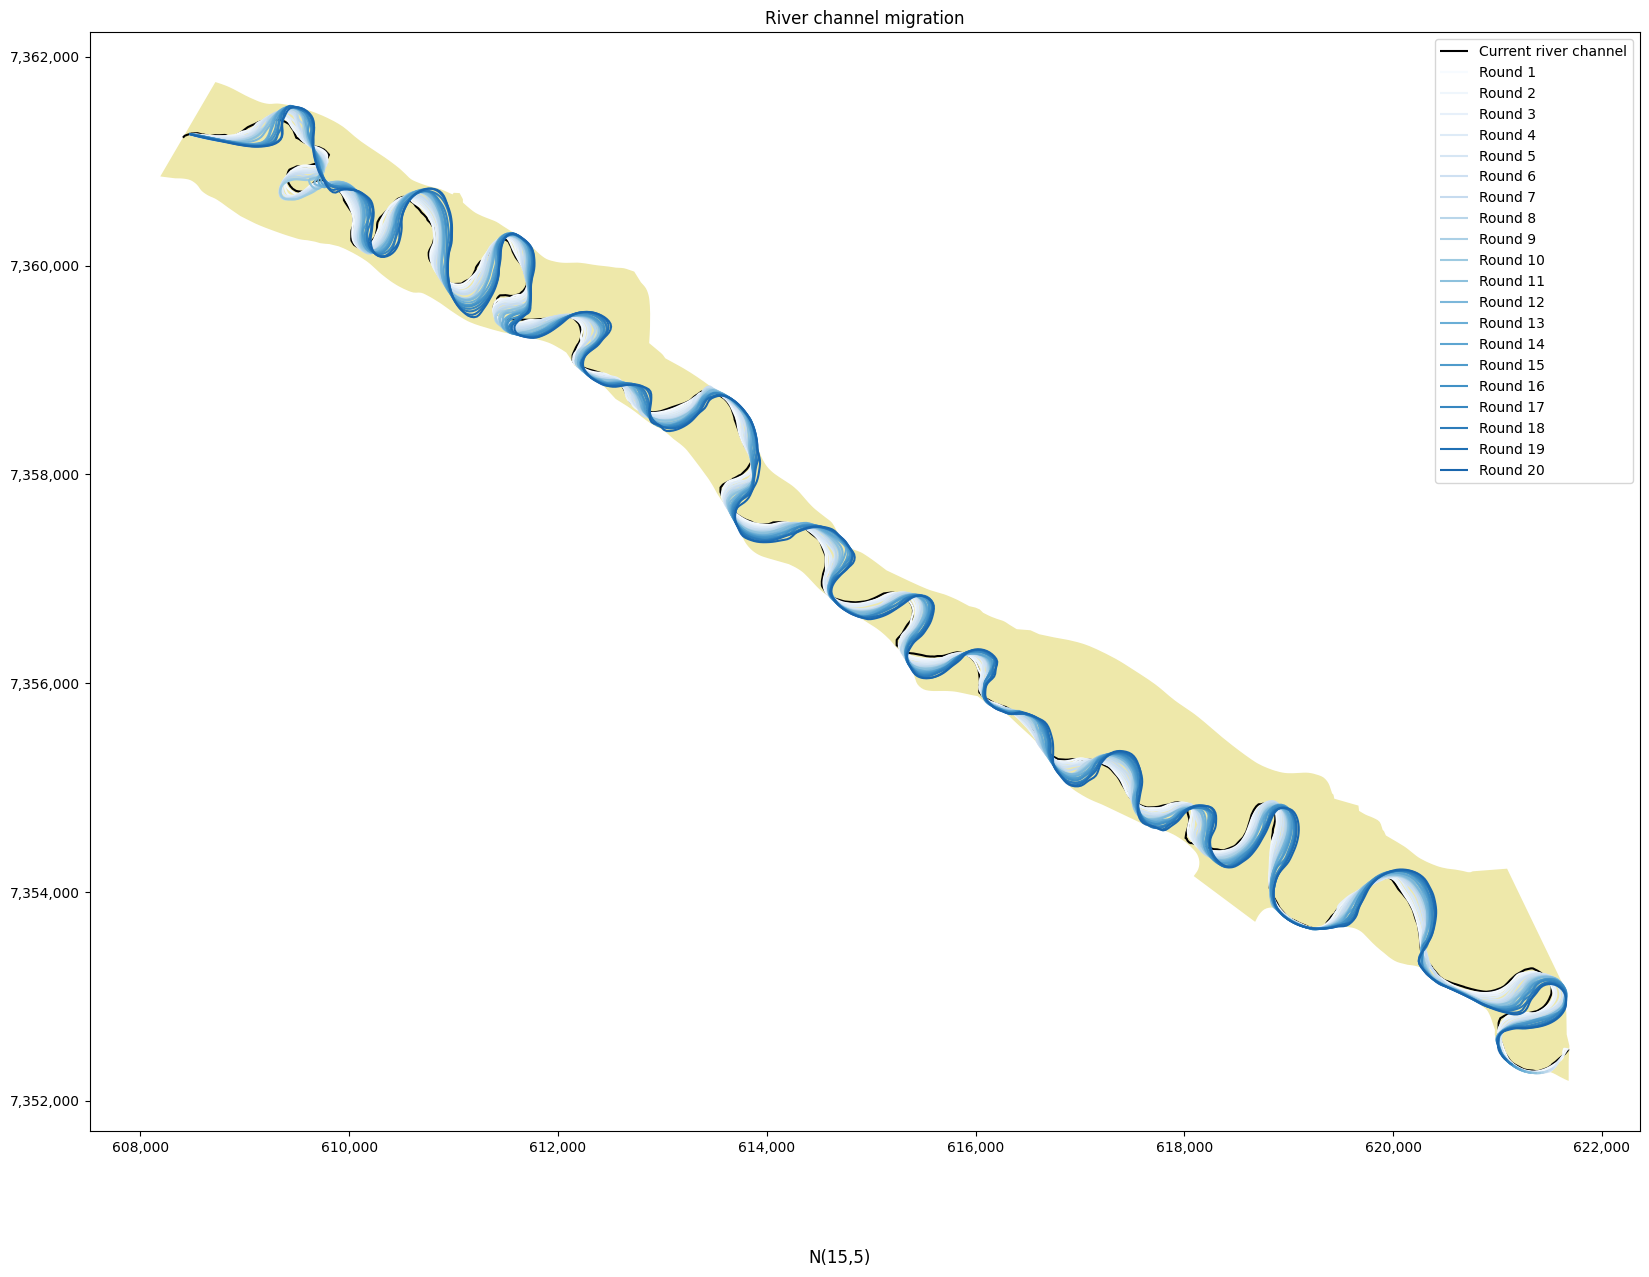

In [22]:
#ALGORITHM

import numpy as np
from shapely.geometry import Point

def reverse_migration_simulation(N_s, channel_path, mean_offset, std_dev_offset, cut_off_distance, feasible_region):
    new_points = {}
    spline = {}
    spline_gdf = {}
    oxbow_points_gdf = {}
    oxbow_points = []

    for s in range(N_s):

        # Initialize a GeoDataFrame to store the new points
        new_points[s] = gpd.GeoDataFrame(columns=['geometry', 'curvature', 'halfmeander'])

        # Inflection points of the current channel path
        inflection_points = define_inflectionpoints(channel_path['geometry'], 4)

        print(len(inflection_points))

        # Define halfmeanders
        define_halfmeander(channel_path, inflection_points)
        # Add into new_points
        new_points[s]['halfmeander'] = channel_path['halfmeander']

        # Define top points
        top = define_top_points(inflection_points, channel_path)
        
        # Radius of circles which are defined by three consecutive points
        radius, interp, sol, A, B = radius_and_intersectionpoint(channel_path)

        # Curvature
        calculate_curvature(channel_path, radius)
        # Add into new_points
        new_points[s]['curvature'] = channel_path['curvature']
        
        # Define the Nhm number of half-meanders of the current channel path
        N_hm = len(inflection_points) - 1
        
        # Define the migration directions
        #D_direction, L_direction = define_directions(inflection_points) # 90

        D_direction, L_direction = define_directions_top(inflection_points, top) # huippu

        print("D", D_direction)
        print("L", L_direction)


        # Sample horizontal and lateral offsets from Gaussian distribution

        '''

        By changing these: 

        1.Pure lateral reverse migration : OD = 0 and OL ~ N(mean,sd), 

        2.Pure reverse downstream migration : OD ~ N(mean, sd) and  OL = 0, 

        3.Mixed reverse migration : OD ~ N(mean, sd) and OL ~ N(mean,sd), 
        

        Migration with accepting/not accepting negative offsets,
        can be modified in function called "offsets"
        
        '''
    
        OD = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OD = np.zeros(N_hm)

        OL = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OL = np.zeros(N_hm)

        # Sample smoothing values sL and sD from a uniform distribution
        
        max_OD = max(np.abs(OD))
        max_OL = max(np.abs(OL))

        min_sD = 0
        max_sD = 2 * max_OD

        min_sL = 0
        max_sL = 2 * max_OL

        sD = np.random.uniform(min_sD, max_sD, N_hm)  # zero if OD is zero
        sL = np.random.uniform(min_sL, max_sL, N_hm) # zero if OL is zero
                            
        # Sample the weighting w
        w = np.random.choice([-1, 1], N_hm) 

        # Initialize a list to store the new points
        newpoint_list = []
        
        for hm in range(N_hm): 
            
            # Filter points of one halfmeander
            pm = (channel_path['halfmeander'] == hm)
            filtered_pm = channel_path[pm]

            mig_D, mig_L = offsets(filtered_pm, OD[hm], OL[hm], sD[hm], sL[hm], w[hm])

            #Move points

            for pn in range(len(filtered_pm['geometry'])):

                new_point = (
                    filtered_pm['geometry'].iloc[pn].x + ((mig_D[pn] * D_direction[hm][0]) + (mig_L[pn] *   L_direction[hm][0])) ,
                    filtered_pm['geometry'].iloc[pn].y + ((mig_D[pn] * D_direction[hm][1]) + (mig_L[pn] *   L_direction[hm][1]))
                    )
                if not np.isnan(new_point).all():
                    newpoint = check_feasible_region(filtered_pm['geometry'].iloc[pn], new_point, feasible_region)
                    newpoint_list.append(newpoint)
                else:
                    newpoint = (filtered_pm['geometry'].iloc[pn].x ,  filtered_pm['geometry'].iloc[pn].y)
                    newpoint_list.append(Point(newpoint)) 
             
                
        # Add new points to the GeoDataFrame
        new_points[s]['geometry'] = newpoint_list

        # Check if new obxbow lakes will appear
        channel_path_deleted_oxbows, oxbows = new_oxbow(channel_path, inflection_points, cut_off_distance)


        # If there is new oxbows
        if len(oxbows) > 0: 
            # Initialize geodataframe again for new points
            new_points[s]=gpd.GeoDataFrame(columns=['geometry'])

            # Add points without oxbow bends
            new_points[s]['geometry'] = [Point((point.x, point.y)) for point in channel_path_deleted_oxbows['geometry']]

            oxbow_points.append(oxbows)

        # Spline
        spline[s], spline_gdf[s] = create_spline((new_points[s]['geometry']).apply(lambda point: (point.x, point.y)).tolist())

        # Update new path to next round
        channel_path = create_breakpoints(spline[s], 75)
        channel_path['geometry'] = channel_path['geometry'].iloc[::-1].values
        
    # Plot
    fig, ax = plt.subplots(figsize=(20, 15))

    def format_eastings(value, pos):
        return f'{int(value):,}'

    def format_northings(value, pos):
            return f'{int(value):,}'

    ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
    ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

    feasible_region.plot(ax=ax, color = 'palegoldenrod')
    
    # Original channel_path
    centerline.plot(ax=ax, color='black', label='Current river channel')
    # Splines of rounds
    for i in range (len(new_points)):
        gradient = np.linspace(0, 1, len(new_points)+5)
        color = plt.cm.Blues(gradient[i])
        gpd.GeoDataFrame(geometry=[spline[i]]).plot(ax=ax, color=color, label=f'Round {i+1}')


    title_txt = "River channel migration"
    plt.title(title_txt)
    suptitle_text = f'N({mean_offset},{std_dev_offset})'
    plt.suptitle(suptitle_text, x=0.5, y=0.05, ha='center')
    plt.legend()
    plt.show()


'''

Input

N_s: Number of simulations.

channel_path: Current river channel.

mean_offset: Average D and L migration distance.
std_dev_offset: Standard deviation of D and L migration distances.

cut_off: Cut-off distance for oxbowlakes.
feasible_region: Feasible region for channel migration.

'''

N_s = 20

channel_path = points

mean_offset = 15
std_dev_offset = 5

cut_off = 150

feasible_region = feasible_region

reverse_migration_simulation(N_s, channel_path, mean_offset, std_dev_offset,  cut_off, feasible_region)
